# Gillespie Algorithm

We have $N$ chemical species $\{S_1,\cdots,S_n\}$ and $M$ chemical reactions between them $\{R_1,\cdots ,R_M\}$

$X_i(t)$ is the amount of molecules (or concentration) of $S_i$. The system is thus described by the vector $\vec x(t)=\{X_1(t),\cdots,X_N(t)\}$.


Each reaction $R_j$ has a state-change vector $\vec v_j = \{v_{1j},\cdots,v_{Nj}\}$, where the quantity $v_{ij}$ is the change that reaction $R_j$ produces on species $S_i$. If the system is in state $\vec x$, reaction $R_j$ changes this state to $\vec x + \vec v_j$.

Each reaction also has a "propensity function" $a_j(\vec x)$, where $a_j(\vec x) dt$ is the probability of the reaction $R_j$ occuring in the time interval $dt$.

The reaction rate equation is:

$$
\frac{d \vec X(t)}{dt} = \sum_{j=1}^M \vec v_j  a_j(\vec X(t))
$$

We define $p_j(\tau,\vec x)$ as the probability (given a state $\vec x$) that the next reaction is $R_j$ and it will occur in a $\tau$ interval. Apparently

$$
p_j(\tau,\vec x) = a_j(\vec x) \exp\left( -\tau a_0(\vec x)\right)
$$

Where $a_0(\vec x)$ is the sum of all the $a_j$s. 

Therefore the stochastic time between reactions is an exponential random varaible with mean $1/a_0(\vec x)$, and the reaction that occurs first can be picked from the $R_j$s with probabilities $a_j(\vec x)/a_0(\vec x)$.

If we include the time as first coordinate on the state vector, $\vec x=\{t,m,r\}$. $x_0=t$, the data can be stored more efficiently.

In [1]:
%run gillespy-numba.py

## Radioactive decay example

In [16]:
c = 0.1

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([c*x_vec[1]])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,-1.] # decay of an atom
    ])

x0 = np.array([0.,1e3]) # t_0=0, x(0)=1k atoms
times = np.arange(0.,60.,5.)

In [17]:
%time model = GillespieModel(a,v)

CPU times: user 4.11 s, sys: 4.08 ms, total: 4.12 s
Wall time: 4.19 s


In [30]:
%%time 

Nsys = 100

means = model.multi_system_evolve(np.array([x0 for _ in range(Nsys)]),times)
data = model.multi_system_step(np.array([x0 for _ in range(Nsys)]),1000)
all_data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))

CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time: 267 ms


(0.0, 55.0)

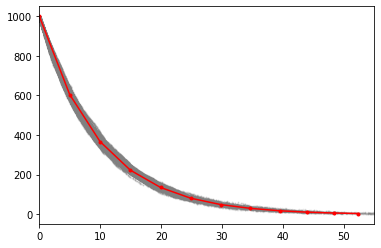

In [31]:
plt.scatter(*all_data.T[[0,1]],s=1,color='gray',alpha=.1)
plt.plot(*np.mean(means,axis=0).T[[0,1]],'.-r')
plt.xlim([min(times),max(times)])

## mARN and protein simple model example

$\vec x = \{t, m,p\}$, where $m$ is molecules of mARN and $p$ of proteins.

In [56]:
cm = 1.0
dm = 0.2
cp = 50
dp = 0.03333333

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([cm, dm*x_vec[1], cp*x_vec[1], dp*x_vec[2]])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,  1.,  0.], # creation of mRNA
        [0., -1.,  0.], # degradation of mRNA
        [0.,  0.,  1.], # creation of protein
        [0.,  0., -1.], # degradation of protein
    ])

x0 = np.array([0.,0.,0.])
times = np.arange(0.,190.,40.)
dt = 0.1

In [57]:
%time model = GillespieModel(a,v)

CPU times: user 3.53 s, sys: 31.2 ms, total: 3.56 s
Wall time: 3.59 s


In [58]:
data = model.multi_system_step(np.array([x0 for _ in range(500)]),60_000)
all_data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))

In [59]:
%time means = model.multi_system_evolve(np.array([x0 for _ in range(100)]),times)

CPU times: user 11.1 s, sys: 15.6 ms, total: 11.1 s
Wall time: 11.7 s


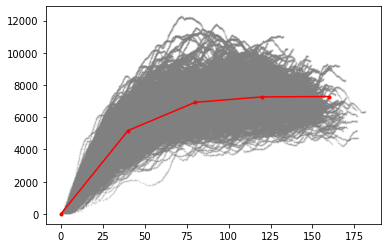

In [60]:
plt.scatter(*all_data[::100].T[[0,2]],s=1,color='gray',alpha=.2)
plt.plot(*np.mean(means,axis=0).T[[0,2]],'.-r')

# Simplest division

$$
\vec x = \{ t,b_{acc}\} 
$$

$$
\dot P = k (s_0 b_{acc})^\lambda \exp(\mu \lambda t) 
$$

only one reaction:
$$
b_{acc} \to b_{acc}/2
$$

In [228]:
k = 15.
λ = 2.0
μ = np.log(2.0)
s0 = 1.0

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([
        k*(s0*x_vec[1])**λ * np.exp(μ*λ*x_vec[0])
    ])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,-x_vec[1]*0.5] # division
    ])

x_0 = np.array([0.,1.0]) 


def size_evaluate(t_simulation,bacc,times):
    r = np.zeros_like(times)
    for i in range(len(times)):
        j = np.searchsorted(t_simulation,times[i],side='right') 
        r[i] = s0*bacc[j-1] * np.exp(μ*times[i])
    return r 

In [229]:
%time model = GillespieModel(a,v)

CPU times: user 4.25 s, sys: 15.8 ms, total: 4.26 s
Wall time: 4.32 s


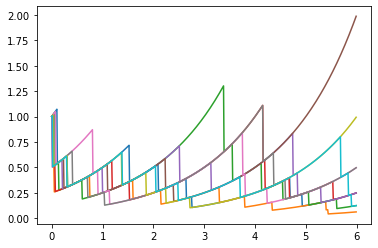

In [231]:
plot_time = np.arange(0.,6.,0.01)

for i in range(10):
    sample = model.single_system_step(x_0,100)
    plt.plot(plot_time,size_evaluate(*sample.T,plot_time))
#plt.yscale('log')

# Random $b$ division

In [263]:
γ = 10.0 # beta distribution parameter
k = 1.
λ = 1.0 
μ = np.log(2.0)
s0 = 1.0

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([
        k*(s0*x_vec[1])**λ * np.exp(μ*λ*x_vec[0])
    ])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    b_new = np.random.beta(γ,γ)
    # first column *must* be zeros
    return np.array([
        [0.,-x_vec[1]*b_new] # division
    ])

x_0 = np.array([0.,1.0]) 

In [264]:
%time model = GillespieModel(a,v)

CPU times: user 6.01 s, sys: 519 ms, total: 6.53 s
Wall time: 12.6 s


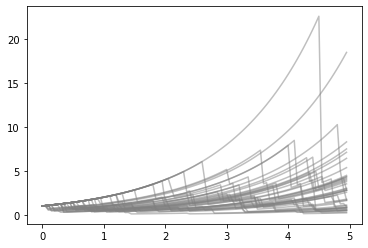

In [272]:
plot_time = np.arange(0.,5.,0.05)

for i in range(40):
    sample = model.single_system_step(x_0,1000)
    plt.plot(plot_time,size_evaluate(*sample.T,plot_time),c='gray',alpha=0.5)

#plt.ylim([0,5])
#plt.yscale('log')

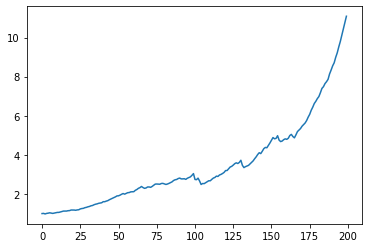

In [266]:
plt.plot(np.mean([size_evaluate(*model.single_system_step(x_0,5000).T,plot_time) for _ in range(100)],axis=0))

## Constitutive gene expression 

Here we develop the deterministic equations system that will rule the expression of a constitutive gene taking into account variations in the amount of polymerases and ribosomes that appear as a consequence of cell growth. Let $z_{pol}$ be defined as the number of polymerases and $z_{rib}$ the number of ribosomes. Let $c_r$ the rate at which the mRNA is transcribed from the gene of interest, $c_p$ the rate at which proteins are translated from the gen of interest, $c_{r_{pol}}$ the rate at which the mRNA whose final product are polymerases is transcribed, $c_{p_{pol}}$ the rate at which the polymerases are synthesized, $c_{r_{rib}}$ is analogous to $c_{r_{pol}}$ but for rybosomes, and so it happens between $c_{p_{rib}}$ and $c_{p_{pol}}$. Moreover, $d_r \left(V\right)$, $d_p \left(V\right)$, $d_{r_{pol}} \left(V\right)$, $d_{p_{pol}} \left(V\right)$, $d_{r_{rib}} \left(V\right)$, $d_{p_{rib}} \left(V\right)$ the terms related to the degradation of the mentioned chemical species. Here is also important to mesure that we used the physics notation $\dot{a} \equiv \frac{da}{dt}$.

\begin{equation}
 \dot{r}_1 = c_r \frac{z_{pol}}{\left<z_{pol}\right>} - d_r \left(V\right) r_1
\end{equation}

\begin{equation}
    \dot{p}_1 = c_p r_1 \frac{z_{rib}}{\left<z_{rib}\right>} - d_p\left(V\right) p_1 
\end{equation}

\begin{equation}
    \dot{r}_{pol} = c_{r_{pol}} \frac{z_{pol}}{\left<z_{pol}\right>} - d_{r_{pol}}\left(V\right) r_{pol}
\end{equation}

\begin{equation}
    \dot{z}_{pol} = c_{p_{pol}} r_{pol }\frac{z_{rib}}{\left<z_{rib}\right>} - d_{p_{pol}}\left(V\right) z_{pol}
\end{equation}

\begin{equation}
    \dot{r}_{rib} = c_{r_{rib}} \frac{z_{pol}}{\left<z_{pol}\right>} - d_{r_{rib}}\left(V\right) r_{rib}
\end{equation}

\begin{equation}
    \dot{z}_{rib} = c_{p_{rib}} r_{rib} \frac{z_{rib}}{\left<z_{rib}\right>}  - d_{p_{rib}}\left(V\right) z_{rib}
\end{equation}

$\vec x = \{t, r,p, rrib, zrib, rpol, zpol\}$, where $r$ represents the molecules of mARN made from the gene, $p$ represents the molecules of proteins made from the gene, $rrib$ represents the molecules of mARN to synthesize ribosomes, $zrib$ represents the molecules of proteins to synthesize ribosomes, $rpol$ represents the molecules of mARN to synthesize polimerases, $zpol$ represents the molecules of proteins to synthesize polimerases.

In [65]:
cr= 1.0
dr = 0.2
cp = 50
dp = 1/2
crpol = 1.0
drpol = 0.2
cppol = 50
dppol = 1/2
crrib = 1.0
drrib = 0.0333
cprib = 50
dprib = 1/2
mean_zpol = 100
mean_zrib = 100


#Every line in a(x_vec) is a different equation.

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([cr*(x_vec[6]/mean_zpol), dr*x_vec[1], \
                     cp*x_vec[1]*(x_vec[4]/mean_zrib),dp*x_vec[2],\
                     crpol*(x_vec[6]/mean_zpol), drpol*x_vec[5], \
                     cppol*x_vec[5]*(x_vec[4]/mean_zrib),dppol*x_vec[6],\
                     crrib*(x_vec[6]/mean_zpol), drrib*x_vec[3], \
                     cprib*x_vec[3]*(x_vec[4]/mean_zrib),dprib*x_vec[4]])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,  1.,  0., 0., 0., 0., 0.], # creation of mRNA from studied gene
        [0., -1.,  0., 0., 0., 0., 0.], # degradation of mRNA from studied gene
        [0.,  0.,  1., 0., 0., 0., 0.], # creation of protein from studied gene
        [0.,  0., -1., 0., 0., 0., 0.], # degradation of protein from studied gene
        [0.,  0.,  0., 1., 0., 0., 0.], # creation of mRNA used to synthesize ribosomes
        [0.,  0.,  0.,-1., 0., 0., 0.], # degradation of mRNA used to synthesize ribosomes
        [0.,  0.,  0., 0., 1., 0., 0.], # creation of ribosomes
        [0.,  0.,  0., 0.,-1., 0., 0.], # degradation of ribosomes
        [0.,  0.,  0., 0., 0., 1., 0.], # creation of mRNA used to synthesize polymerases
        [0.,  0.,  0., 0., 0.,-1., 0.], # degradation of mRNA used to synthesize polymerases
        [0.,  0.,  0., 0., 0., 0., 1.], # creation of polymerases
        [0.,  0.,  0., 0., 0., 0.,-1.], # degradation of polymerases
        
    ])

x0 = np.array([0.,0.,0.,0.,1.,0.,1.])
times = np.arange(0.,190.,40.)
dt = 0.1

In [66]:
model = GillespieModel(a,v)

In [67]:
data = model.single_system_step(x0, 1_000)

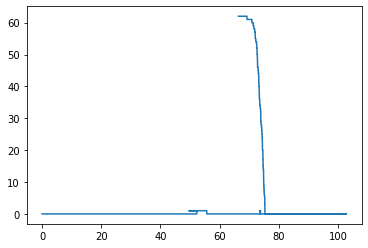

In [72]:
plt.step(*data.T[[0,2]])

In [ ]:
data = model.multi_system_step(np.array([x0 for _ in range(10)]),60_000)
all_data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
means = model.multi_system_evolve(np.array([x0 for _ in range(100)]),times)
plt.scatter(*all_data[::100].T[[0,2]],s=1,color='gray',alpha=.2)
plt.plot(*np.mean(means,axis=0).T[[0,2]],'.-r')